# Large Scale Distributed Seismic Processing - Poseidon Dataset

This is a workflow where we will work through performing calculations on post-stack seismic data using cloud computing.

We will use this Jupyter notebook to walk through the steps, S3 to store the data, and Lambda to do the processing.

The seismic data is streamed from S3 without the need to duplicate any portion of it. This is ideal for situations where you need to work with large (+100GB) SEGY files that cannot always be loaded into memory and to also avoid the cost of making a duplicate on a local filesystem. S3 allows you to read specific bytes of data from the file allowing for reading and processing of the traces you need. Lambda will allow you to parallel process the data and with no need to provision any hardware, you only pay for the time it takes to perform the calculations.


### Import packages

In [3]:
import sys
import time
import json
import boto3
import struct
import pickle
import botocore
import array as arr
import numpy as np
import matplotlib.pyplot as plt
from struct import Struct

### Functions

Below are some custom fuctions that load SEGY revision 1 data.  They will aid in decifering the SEGY format.

In [4]:
# Decode the text header block
def DecodeTextHeader(text_header_raw):
    text_header = text_header_raw.decode('cp500')
    text_header = text_header.replace("C 1 ", "\nC 1 ")
    text_header = text_header.replace("C 2 ", "\nC 2 ")
    text_header = text_header.replace("C 3 ", "\nC 3 ")
    text_header = text_header.replace("C 4 ", "\nC 4 ")
    text_header = text_header.replace("C 5 ", "\nC 5 ")
    text_header = text_header.replace("C 6 ", "\nC 6 ")
    text_header = text_header.replace("C 7 ", "\nC 7 ")
    text_header = text_header.replace("C 8 ", "\nC 8 ")
    text_header = text_header.replace("C 9 ", "\nC 9 ")
    text_header = text_header.replace("C10 ", "\nC10 ")
    text_header = text_header.replace("C11 ", "\nC11 ")
    text_header = text_header.replace("C12 ", "\nC12 ")
    text_header = text_header.replace("C13 ", "\nC13 ")
    text_header = text_header.replace("C14 ", "\nC14 ")
    text_header = text_header.replace("C15 ", "\nC15 ")
    text_header = text_header.replace("C16 ", "\nC16 ")
    text_header = text_header.replace("C17 ", "\nC17 ")
    text_header = text_header.replace("C18 ", "\nC18 ")
    text_header = text_header.replace("C19 ", "\nC19 ")
    text_header = text_header.replace("C20 ", "\nC20 ")
    text_header = text_header.replace("C21 ", "\nC21 ")
    text_header = text_header.replace("C22 ", "\nC22 ")
    text_header = text_header.replace("C23 ", "\nC23 ")
    text_header = text_header.replace("C24 ", "\nC24 ")
    text_header = text_header.replace("C25 ", "\nC25 ")
    text_header = text_header.replace("C26 ", "\nC26 ")
    text_header = text_header.replace("C27 ", "\nC27 ")
    text_header = text_header.replace("C28 ", "\nC28 ")
    text_header = text_header.replace("C29 ", "\nC29 ")
    text_header = text_header.replace("C30 ", "\nC30 ")
    text_header = text_header.replace("C31 ", "\nC31 ")
    text_header = text_header.replace("C32 ", "\nC32 ")
    text_header = text_header.replace("C33 ", "\nC33 ")
    text_header = text_header.replace("C34 ", "\nC34 ")
    text_header = text_header.replace("C35 ", "\nC35 ")
    text_header = text_header.replace("C36 ", "\nC36 ")
    text_header = text_header.replace("C37 ", "\nC37 ")
    text_header = text_header.replace("C38 ", "\nC38 ")
    text_header = text_header.replace("C39 ", "\nC39 ")
    text_header = text_header.replace("C40 ", "\nC40 ")
    
    return text_header

# Decode the binary header block
def DecodeBinHeader(bin_header_raw):
    bin_header = {}

    bin_header['job_id']                  = int.from_bytes(bin_header_raw[0:4], byteorder='big', signed=False)
    bin_header['line_no']                 = int.from_bytes(bin_header_raw[4:8], byteorder='big', signed=False)
    bin_header['reel_no']                 = int.from_bytes(bin_header_raw[8:12], byteorder='big', signed=False)
    bin_header['data_traces']             = int.from_bytes(bin_header_raw[12:14], byteorder='big', signed=False)
    bin_header['aux_traces']              = int.from_bytes(bin_header_raw[14:16], byteorder='big', signed=False)
    bin_header['sample_interval']         = int.from_bytes(bin_header_raw[16:18], byteorder='big', signed=False)
    bin_header['sample_interval_orig']    = int.from_bytes(bin_header_raw[18:20], byteorder='big', signed=False)
    bin_header['samples_per_trace']       = int.from_bytes(bin_header_raw[20:22], byteorder='big', signed=False)
    bin_header['samples_per_trace_orig']  = int.from_bytes(bin_header_raw[22:24], byteorder='big', signed=False)
    bin_header['data_sample_format']      = int.from_bytes(bin_header_raw[24:26], byteorder='big', signed=False)
    bin_header['ensemble_fold']           = int.from_bytes(bin_header_raw[26:28], byteorder='big', signed=False)
    bin_header['trace_sorting']           = int.from_bytes(bin_header_raw[28:30], byteorder='big', signed=False)
    bin_header['vert_sum_code']           = int.from_bytes(bin_header_raw[30:32], byteorder='big', signed=False)
    bin_header['sweep_hz_start']          = int.from_bytes(bin_header_raw[32:34], byteorder='big', signed=False)
    bin_header['sweep_hz_end']            = int.from_bytes(bin_header_raw[34:36], byteorder='big', signed=False)
    bin_header['sweep_length']            = int.from_bytes(bin_header_raw[36:38], byteorder='big', signed=False)
    bin_header['sweep_type']              = int.from_bytes(bin_header_raw[38:40], byteorder='big', signed=False)
    bin_header['sweep_trace_ch']          = int.from_bytes(bin_header_raw[40:42], byteorder='big', signed=False)
    bin_header['sweep_trace_taper_start'] = int.from_bytes(bin_header_raw[42:44], byteorder='big', signed=False)
    bin_header['sweep_trace_taper_end']   = int.from_bytes(bin_header_raw[44:46], byteorder='big', signed=False)
    bin_header['taper_type']              = int.from_bytes(bin_header_raw[46:48], byteorder='big', signed=False)
    bin_header['data_traces_correlated']  = int.from_bytes(bin_header_raw[48:50], byteorder='big', signed=False)
    bin_header['binary_gain_recovered']   = int.from_bytes(bin_header_raw[50:52], byteorder='big', signed=False)
    bin_header['amp_recovery_method']     = int.from_bytes(bin_header_raw[52:54], byteorder='big', signed=False)
    bin_header['measurement_system']      = int.from_bytes(bin_header_raw[54:56], byteorder='big', signed=False)
    bin_header['impulse_sig_polarity']    = int.from_bytes(bin_header_raw[56:58], byteorder='big', signed=False)
    bin_header['vib_polarity']            = int.from_bytes(bin_header_raw[58:60], byteorder='big', signed=False)
    bin_header['unassigned']              = int.from_bytes(bin_header_raw[60:300], byteorder='big', signed=False)
    bin_header['segy_format']             = int.from_bytes(bin_header_raw[300:302], byteorder='big', signed=False)
    bin_header['fixed_length_flag']       = int.from_bytes(bin_header_raw[302:304], byteorder='big', signed=False)
    bin_header['extended_text_header_no'] = int.from_bytes(bin_header_raw[304:306], byteorder='big', signed=False)
    bin_header['unassigned2']             = int.from_bytes(bin_header_raw[306:400], byteorder='big', signed=False)
    
    return bin_header

# Display the binary header data.
def PrintBinHeader(bin_header):
    print("job_id                  = ", bin_header['job_id']                 )
    print("line_no                 = ", bin_header['line_no']                )
    print("reel_no                 = ", bin_header['reel_no']                )
    print("data_traces             = ", bin_header['data_traces']            )
    print("aux_traces              = ", bin_header['aux_traces']             )
    print("sample_interval         = ", bin_header['sample_interval']        )
    print("sample_interval_orig    = ", bin_header['sample_interval_orig']   )
    print("samples_per_trace       = ", bin_header['samples_per_trace']      )
    print("samples_per_trace_orig  = ", bin_header['samples_per_trace_orig'] )
    print("data_sample_format      = ", bin_header['data_sample_format']     )
    print("ensemble_fold           = ", bin_header['ensemble_fold']          )
    print("trace_sorting           = ", bin_header['trace_sorting']          )
    print("vert_sum_code           = ", bin_header['vert_sum_code']          )
    print("sweep_hz_start          = ", bin_header['sweep_hz_start']         )
    print("sweep_hz_end            = ", bin_header['sweep_hz_end']           )
    print("sweep_length            = ", bin_header['sweep_length']           )
    print("sweep_type              = ", bin_header['sweep_type']             )
    print("sweep_trace_ch          = ", bin_header['sweep_trace_ch']         )
    print("sweep_trace_taper_start = ", bin_header['sweep_trace_taper_start'])
    print("sweep_trace_taper_end   = ", bin_header['sweep_trace_taper_end']  )
    print("taper_type              = ", bin_header['taper_type']             )
    print("data_traces_correlated  = ", bin_header['data_traces_correlated'] )
    print("binary_gain_recovered   = ", bin_header['binary_gain_recovered']  )
    print("amp_recovery_method     = ", bin_header['amp_recovery_method']    )
    print("measurement_system      = ", bin_header['measurement_system']     )
    print("impulse_sig_polarity    = ", bin_header['impulse_sig_polarity']   )
    print("vib_polarity            = ", bin_header['vib_polarity']           )
    print("unassigned              = ", bin_header['unassigned']             )
    print("segy_format             = ", bin(bin_header['segy_format'])[2:]   )    
    print("fixed_length_flag       = ", bin_header['fixed_length_flag']      )
    print("extended_text_header_no = ", bin_header['extended_text_header_no'])
    print("unassigned2             = ", bin_header['unassigned2']            )
    
# Decode a binary trade header.
def DecodeTraceHeader(trace_header_raw):
    trace_header = {}
    trace_header['trace_seq_no_all']            = int.from_bytes(trace_header_raw[0:4], byteorder='big', signed=False)
    trace_header['trace_seq_no_file']           = int.from_bytes(trace_header_raw[4:8], byteorder='big', signed=False)
    trace_header['field_record_no_orig']        = int.from_bytes(trace_header_raw[8:12], byteorder='big', signed=False)
    trace_header['trace_no_field_orig']         = int.from_bytes(trace_header_raw[12:16], byteorder='big', signed=False)
    trace_header['energy_source_point_no']      = int.from_bytes(trace_header_raw[16:20], byteorder='big', signed=False)
    trace_header['ensemble_no']                 = int.from_bytes(trace_header_raw[20:24], byteorder='big', signed=False)
    trace_header['ensemble_trace_no']           = int.from_bytes(trace_header_raw[24:28], byteorder='big', signed=False)
    trace_header['trace_id']                    = int.from_bytes(trace_header_raw[28:30], byteorder='big', signed=False)
    trace_header['sum_vertical_traces']         = int.from_bytes(trace_header_raw[30:32], byteorder='big', signed=False)
    trace_header['sum_horizontal_traces']       = int.from_bytes(trace_header_raw[32:34], byteorder='big', signed=False)
    trace_header['data_use']                    = int.from_bytes(trace_header_raw[34:36], byteorder='big', signed=False)
    trace_header['distance_from_source_center'] = int.from_bytes(trace_header_raw[36:40], byteorder='big', signed=False)
    # ... incomplete
    trace_header['group_x']                     = int.from_bytes(trace_header_raw[80:84], byteorder='big', signed=False)
    trace_header['group_y']                     = int.from_bytes(trace_header_raw[84:88], byteorder='big', signed=False)
    trace_header['coord_units']                 = int.from_bytes(trace_header_raw[88:90], byteorder='big', signed=False)
    trace_header['trace_samples']               = int.from_bytes(trace_header_raw[114:116], byteorder='big', signed=False)
    trace_header['sample_interval']             = int.from_bytes(trace_header_raw[116:118], byteorder='big', signed=False)
    trace_header['gain_type']                   = int.from_bytes(trace_header_raw[118:120], byteorder='big', signed=False)
    trace_header['CDP_X']                       = int.from_bytes(trace_header_raw[180:184], byteorder='big', signed=False)
    trace_header['CDP_Y']                       = int.from_bytes(trace_header_raw[184:188], byteorder='big', signed=False)
    trace_header['inline']                      = int.from_bytes(trace_header_raw[188:192], byteorder='big', signed=False)
    trace_header['xline']                       = int.from_bytes(trace_header_raw[192:196], byteorder='big', signed=False)
    trace_header['trace_unit']                  = int.from_bytes(trace_header_raw[202:204], byteorder='big', signed=False) 
    trace_header['inline_custom']               = int.from_bytes(trace_header_raw[232:236], byteorder='big', signed=False)
    trace_header['xline_custom']                = int.from_bytes(trace_header_raw[236:240], byteorder='big', signed=False)

    return trace_header
    
# Display the trade header data.
def PrintTraceHeaders(trace_header):
    print("trace_seq_no_all            = ", trace_header['trace_seq_no_all'])
    print("trace_seq_no_file           = ", trace_header['trace_seq_no_file'])
    print("field_record_no_orig        = ", trace_header['field_record_no_orig'])
    print("trace_no_field_orig         = ", trace_header['trace_no_field_orig'])
    print("energy_source_point_no      = ", trace_header['energy_source_point_no'])
    print("ensemble_no                 = ", trace_header['ensemble_no'])
    print("ensemble_trace_no           = ", trace_header['ensemble_trace_no'])
    print("trace_id                    = ", trace_header['trace_id'])
    print("sum_vertical_traces         = ", trace_header['sum_vertical_traces'])
    print("sum_horizontal_traces       = ", trace_header['sum_horizontal_traces'])
    print("data_use                    = ", trace_header['data_use'])
    print("distance_from_source_center = ", trace_header['distance_from_source_center'])
    # ... incomplete
    print("group_x                     = ", trace_header['group_x'])
    print("group_y                     = ", trace_header['group_y'])
    print("coord_units                 = ", trace_header['coord_units'])
    print("trace_samples               = ", trace_header['trace_samples'])
    print("sample_interval             = ", trace_header['sample_interval'])
    print("gain_type                   = ", trace_header['gain_type'])
    print("CDP_X                       = ", trace_header['CDP_X'])          
    print("CDP_Y                       = ", trace_header['CDP_Y'])          
    print("inline                      = ", trace_header['inline'])         
    print("xline                       = ", trace_header['xline'])          
    print("trace_unit                  = ", trace_header['trace_unit'])     
    print("inline_custom               = ", trace_header['inline_custom'])         
    print("xline_custom                = ", trace_header['xline_custom'])          


### Load SEGY
We will load the SEGY file from S3 and create a StreamingBody object we can use to stream data into the notebook.  We do not need to copy the file locally, we will stream data bit-by-bit as needed.  

You should modify these variables to point towards your own S3 bucket and SEGY file.  

In [5]:
# Load in the 100GB SEGY data

source_bucket   = 'geophysics-on-cloud'                 # S3 bucket name with input data
source_folder   = 'poseidon/seismic/segy'               # Folder path
source_filename = 'psdn11_TbsdmF_full_w_AGC_Nov11.segy' # Filename

s3 = boto3.resource('s3')
segy_obj = s3.Object(source_bucket, f"{source_folder}/{source_filename}")
segy_stream = segy_obj.get()['Body']

### Read Headers
Lets read the text and binary headers of the SEGY file.  We are assuming the file follows the SEGY Rev1 standard, which is the case for this file.

In this format, the first 3200 bytes are the text header, the next 400 are the binary headers, so we are saving it to variables.

In [6]:
text_header_raw = segy_stream.read(3200)
bin_header_raw = segy_stream.read(400)

text_header = DecodeTextHeader(text_header_raw)

print("Text Header:")
print(text_header)

bin_header = DecodeBinHeader(bin_header_raw)
print("\nBinary Header:")
PrintBinHeader(bin_header)

Text Header:

C 1 SEGY OUTPUT FROM Petrel 2016.3 (64-bit) Wednesday, September 13 2017 15:31:3
C 2 Name: psdn11_TbsdmF_full_w_AGC_Nov11 Type: 3D seismic                       
C 3                                                                             
C 4 First inline: 983    Last inline: 4419                                      
C 5 First xline:  504    Last xline:  5556                                      
C 6 CRS: Undefined                                                              
C 7 X min: 367745.62 max: 457555.83 delta: 89810.21                             
C 8 Y min: 8447583.17 max: 8537551.31 delta: 89968.14                           
C 9 Time min: -6002.00 max: 2.00 delta: 6004.00                                 
C10 Lat min: - max: - delta: -                                                  
C11 Long min: - max: - delta: -                                                 
C12 Trace min: -6000.00 max: 0.00 delta: 6000.00                                
C13 Seismic (t

### Traces
After the file headers, the remainder of the SEGY consists of pairs of trace header blocks and the actual trace values in sequence.

Lets read one of the binary trace headers.  This dataset contains a handful of traces without amplitudes, so we will skip a few traces at first to check to see the data is being read correctly.

In [7]:
# Skip a 1000 traces, as the first handful do not have any usable data.
skip_no = 1000

for x in range(0, skip_no):
    trace_header_raw = segy_stream.read(240)
    trace_header = DecodeTraceHeader(trace_header_raw)
    trace_raw = segy_stream.read(trace_header['trace_samples']*4)

trace_header_raw = segy_stream.read(240)
trace_header = DecodeTraceHeader(trace_header_raw)
PrintTraceHeaders(trace_header)

trace_seq_no_all            =  1001
trace_seq_no_file           =  983
field_record_no_orig        =  983
trace_no_field_orig         =  1001
energy_source_point_no      =  0
ensemble_no                 =  1504
ensemble_trace_no           =  1
trace_id                    =  1
sum_vertical_traces         =  0
sum_horizontal_traces       =  0
data_use                    =  1
distance_from_source_center =  0
group_x                     =  0
group_y                     =  0
coord_units                 =  1
trace_samples               =  1501
sample_interval             =  4000
gain_type                   =  0
CDP_X                       =  40655665
CDP_Y                       =  845562942
inline                      =  983
xline                       =  1504
trace_unit                  =  0
inline_custom               =  0
xline_custom                =  0


### Trace Data
SEGY stores the trace amplitudes in different formats, outlined by the binary header "data_sample_format".  

In this file the trace data is in IEEE 4-byte float, which is directly useable in Python.  We do not need to convert it, but only unpack it from the byte format.

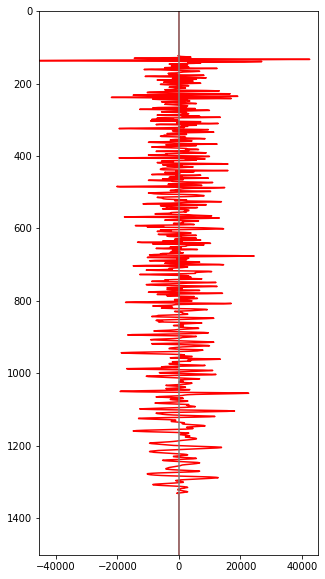

In [8]:
trace_raw = segy_stream.read(trace_header['trace_samples']*4)

trace = []
for x in range(4, trace_header['trace_samples']*4+4, 4):
    trace.append(struct.unpack('>f', trace_raw[x-4:x])[0])

# Lets plot the trace
limits = np.amax(np.absolute(trace))
plt.figure(figsize=(5, 10))
plt.plot(trace, range(trace_header['trace_samples']), 'red')
plt.xlim(-limits, limits)
plt.ylim(trace_header['trace_samples'], 0)
plt.axvline(0, c='grey')

In [9]:
segy_stream.close()

### Process Data on EC2/SageMaker Notebook

First, for a benchmark, lets start processing here and see how long it would take on a single vCPU.

In [25]:
segy_stream = segy_obj.get()['Body']

text_header_raw = segy_stream.read(3200)
bin_header_raw = segy_stream.read(400)
text_header = DecodeTextHeader(text_header_raw)
bin_header = DecodeBinHeader(bin_header_raw)

In [26]:
trace_amp_mean = {}
start_time = time.time()

# Iterate through all the traces
while True:
    trace_header_raw = segy_stream.read(240)
    trace_header = DecodeTraceHeader(trace_header_raw)
    trace_raw = segy_stream.read(trace_header['trace_samples']*4)

    trace = []
    for x in range(4, trace_header['trace_samples']*4+4, 4):
        trace.append(struct.unpack('>f', trace_raw[x-4:x])[0])
    
    trace_amp_mean[trace_header['trace_seq_no_all']] = np.mean(np.absolute(trace))
    
    if trace_header['trace_seq_no_all']%1000 == 0:
        print("Trace #{} has a mean amplitude of {}, elapse time is {:.2f} seconds.".format(
                                        trace_header['trace_seq_no_all'], 
                                        trace_amp_mean[trace_header['trace_seq_no_all']], 
                                        time.time() - start_time))
        
    if trace_header['trace_seq_no_all'] > 5000:
        print("Stopping here.")
        break

segy_stream.close()

Trace #1000 has a mean amplitude of 4078.4623089726665, elapse time is 0.94 seconds.
Trace #2000 has a mean amplitude of 3997.4926979682605, elapse time is 1.88 seconds.
Trace #3000 has a mean amplitude of 4038.0955286038125, elapse time is 2.81 seconds.
Trace #4000 has a mean amplitude of 4013.7809996877722, elapse time is 3.75 seconds.
Trace #5000 has a mean amplitude of 0.0006587009993381798, elapse time is 4.70 seconds.
Stopping here.


### Scale Out

Processing the SEGY file with a single machine is quite slow.  It would take about 4 hours to complete on this T2.Medium instance.  We could scale up and use a more powerful instance type, but then we are paying per hour, even if we are not using the full compute capacity.  Futhermore will will have to code the parallel processing.  It can quickly start becoming expensive to leave the machines running and the code complexity will increase.  The flow would look like the image below:


![title](images/Page-1.png)


So lets leverage the power of the cloud to scale out and distribute the processing workload with on-demand processing, Lambda!  Lets split this workload and send it to 1000 Lambdas that can run in parallel.  We do not need to send any seismic data to Lambda, we will simply tell each one where to find the file on S3 and which portion of the file to load.


![title](images/Page-2.png)


If you are following along with the GitHub repo and using the CloudFormation template, put in the bucket name you created when deploying the template.

There is a Lambda function that contains the same calculations we performed above called [SegyBatchProcessMeanAmp](https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/SegyBatchProcessMeanAmp).  If you want, go check it out in the AWS Console.  It was deployed with the CF template.
Lets get things setup up below.  Adjust variables below:

**lambda_name** - Visit the Lambda page in the AWS Console and see what the final name is for your. 

**results_bucket** - Rename to the S3 bucket you created with the CloudFormation template.

In [16]:
lambda_name        = "Seismic-Lambdas-4-SegyMeanAmpLambda-15NCECNNVG6X2"    # Name of the Lambda function to invoke
results_bucket     = "seismic-results-vavourak-4"                           # Bucket to use
mean_amp_folder    = "temp-trace-bundles-poseidon-mean-amp"                 # Subfolder to place the calculation results
concurrent_lambdas = 1000                                                   # Number of Lambdas to invoke

Now lets split up the SEGY file into byte ranges and invoke 1000 Lambda functions.

In [17]:
# Get S3 object
segy_obj = s3.Object(source_bucket, f"{source_folder}/{source_filename}")

# Define some needed variables based off the above parameters
start_time = time.time()
header_size = 3600
trace_header_size = 240
trace_size = bin_header['samples_per_trace'] * 4
trace_size_with_headers = trace_size + trace_header_size
filesize = segy_obj.content_length
trace_count = int((filesize - 3600) / trace_size_with_headers)
bundle_size = round(trace_count/concurrent_lambdas)
lambda_counter = 0

lambda_client = boto3.client('lambda')

results_file_list = [] # Lets keep track of the output file names, so we can grab them later

print(f"Total traces in file: {trace_count}")
print(f"Traces per Lambda for {concurrent_lambdas} concurrency (not rounded): {trace_count/concurrent_lambdas}")
print(f"Traces per Lambda, rounded up: {round(trace_count/concurrent_lambdas+0.5)}")

Total traces in file: 17367161
Traces per Lambda for 1000 concurrency (not rounded): 17367.161
Traces per Lambda, rounded up: 17368


In [18]:
# Send the trace bundle information over to Lambda
for bundle in range(0, int(trace_count), bundle_size):
    lambda_counter = lambda_counter + 1
    bytes_start = bundle * trace_size_with_headers + header_size
    bytes_stop = (bundle + bundle_size) * trace_size_with_headers + header_size - 1
    print(f"Lambda #{lambda_counter}, bundled traces: {bundle}-{bundle+bundle_size}, bytes: {bytes_start}-{bytes_stop}.")
    
    # Build the message for the Lambda to find the files
    payload = {
        "bucket_in"          : source_bucket,
        "folder_in"          : source_folder,
        "filename_in"        : source_filename,
        "bucket_out"         : results_bucket,
        "folder_out"         : mean_amp_folder,
        "bytes_start"        : bytes_start,
        "bytes_stop"         : bytes_stop,
        "use_custom_lines"   : 0,
        "data_sample_format" : bin_header['data_sample_format']
    }

    # Invoke the Lambda SegyBatchProcessMeanAmp
    response = lambda_client.invoke(FunctionName=lambda_name,
                                    InvocationType='Event',
                                    Payload=json.dumps(payload))

    results_file_list.append(f"{mean_amp_folder}/{source_filename}.{bytes_start}-{bytes_stop}.pkl")
    
print("Done!  Elapse time to gather traces and send to Lambda: {:0.2f} seconds, now waiting a bit for processing to complete.".format(time.time() - start_time))

time.sleep(200)      # Waiting before carrying on next steps, to allow time for Lambda to finish.

Lambda #1, bundled traces: 0-17367, bytes: 3600-108443147.
Lambda #2, bundled traces: 17367-34734, bytes: 108443148-216882695.
Lambda #3, bundled traces: 34734-52101, bytes: 216882696-325322243.
Lambda #4, bundled traces: 52101-69468, bytes: 325322244-433761791.
Lambda #5, bundled traces: 69468-86835, bytes: 433761792-542201339.
Lambda #6, bundled traces: 86835-104202, bytes: 542201340-650640887.
Lambda #7, bundled traces: 104202-121569, bytes: 650640888-759080435.
Lambda #8, bundled traces: 121569-138936, bytes: 759080436-867519983.
Lambda #9, bundled traces: 138936-156303, bytes: 867519984-975959531.
Lambda #10, bundled traces: 156303-173670, bytes: 975959532-1084399079.
Lambda #11, bundled traces: 173670-191037, bytes: 1084399080-1192838627.
Lambda #12, bundled traces: 191037-208404, bytes: 1192838628-1301278175.
Lambda #13, bundled traces: 208404-225771, bytes: 1301278176-1409717723.
Lambda #14, bundled traces: 225771-243138, bytes: 1409717724-1518157271.
Lambda #15, bundled traces

Lambda #117, bundled traces: 2014572-2031939, bytes: 12578991168-12687430715.
Lambda #118, bundled traces: 2031939-2049306, bytes: 12687430716-12795870263.
Lambda #119, bundled traces: 2049306-2066673, bytes: 12795870264-12904309811.
Lambda #120, bundled traces: 2066673-2084040, bytes: 12904309812-13012749359.
Lambda #121, bundled traces: 2084040-2101407, bytes: 13012749360-13121188907.
Lambda #122, bundled traces: 2101407-2118774, bytes: 13121188908-13229628455.
Lambda #123, bundled traces: 2118774-2136141, bytes: 13229628456-13338068003.
Lambda #124, bundled traces: 2136141-2153508, bytes: 13338068004-13446507551.
Lambda #125, bundled traces: 2153508-2170875, bytes: 13446507552-13554947099.
Lambda #126, bundled traces: 2170875-2188242, bytes: 13554947100-13663386647.
Lambda #127, bundled traces: 2188242-2205609, bytes: 13663386648-13771826195.
Lambda #128, bundled traces: 2205609-2222976, bytes: 13771826196-13880265743.
Lambda #129, bundled traces: 2222976-2240343, bytes: 13880265744

Lambda #227, bundled traces: 3924942-3942309, bytes: 24507341448-24615780995.
Lambda #228, bundled traces: 3942309-3959676, bytes: 24615780996-24724220543.
Lambda #229, bundled traces: 3959676-3977043, bytes: 24724220544-24832660091.
Lambda #230, bundled traces: 3977043-3994410, bytes: 24832660092-24941099639.
Lambda #231, bundled traces: 3994410-4011777, bytes: 24941099640-25049539187.
Lambda #232, bundled traces: 4011777-4029144, bytes: 25049539188-25157978735.
Lambda #233, bundled traces: 4029144-4046511, bytes: 25157978736-25266418283.
Lambda #234, bundled traces: 4046511-4063878, bytes: 25266418284-25374857831.
Lambda #235, bundled traces: 4063878-4081245, bytes: 25374857832-25483297379.
Lambda #236, bundled traces: 4081245-4098612, bytes: 25483297380-25591736927.
Lambda #237, bundled traces: 4098612-4115979, bytes: 25591736928-25700176475.
Lambda #238, bundled traces: 4115979-4133346, bytes: 25700176476-25808616023.
Lambda #239, bundled traces: 4133346-4150713, bytes: 25808616024

Lambda #334, bundled traces: 5783211-5800578, bytes: 36110373084-36218812631.
Lambda #335, bundled traces: 5800578-5817945, bytes: 36218812632-36327252179.
Lambda #336, bundled traces: 5817945-5835312, bytes: 36327252180-36435691727.
Lambda #337, bundled traces: 5835312-5852679, bytes: 36435691728-36544131275.
Lambda #338, bundled traces: 5852679-5870046, bytes: 36544131276-36652570823.
Lambda #339, bundled traces: 5870046-5887413, bytes: 36652570824-36761010371.
Lambda #340, bundled traces: 5887413-5904780, bytes: 36761010372-36869449919.
Lambda #341, bundled traces: 5904780-5922147, bytes: 36869449920-36977889467.
Lambda #342, bundled traces: 5922147-5939514, bytes: 36977889468-37086329015.
Lambda #343, bundled traces: 5939514-5956881, bytes: 37086329016-37194768563.
Lambda #344, bundled traces: 5956881-5974248, bytes: 37194768564-37303208111.
Lambda #345, bundled traces: 5974248-5991615, bytes: 37303208112-37411647659.
Lambda #346, bundled traces: 5991615-6008982, bytes: 37411647660

Lambda #440, bundled traces: 7624113-7641480, bytes: 47604965172-47713404719.
Lambda #441, bundled traces: 7641480-7658847, bytes: 47713404720-47821844267.
Lambda #442, bundled traces: 7658847-7676214, bytes: 47821844268-47930283815.
Lambda #443, bundled traces: 7676214-7693581, bytes: 47930283816-48038723363.
Lambda #444, bundled traces: 7693581-7710948, bytes: 48038723364-48147162911.
Lambda #445, bundled traces: 7710948-7728315, bytes: 48147162912-48255602459.
Lambda #446, bundled traces: 7728315-7745682, bytes: 48255602460-48364042007.
Lambda #447, bundled traces: 7745682-7763049, bytes: 48364042008-48472481555.
Lambda #448, bundled traces: 7763049-7780416, bytes: 48472481556-48580921103.
Lambda #449, bundled traces: 7780416-7797783, bytes: 48580921104-48689360651.
Lambda #450, bundled traces: 7797783-7815150, bytes: 48689360652-48797800199.
Lambda #451, bundled traces: 7815150-7832517, bytes: 48797800200-48906239747.
Lambda #452, bundled traces: 7832517-7849884, bytes: 48906239748

Lambda #553, bundled traces: 9586584-9603951, bytes: 59858634096-59967073643.
Lambda #554, bundled traces: 9603951-9621318, bytes: 59967073644-60075513191.
Lambda #555, bundled traces: 9621318-9638685, bytes: 60075513192-60183952739.
Lambda #556, bundled traces: 9638685-9656052, bytes: 60183952740-60292392287.
Lambda #557, bundled traces: 9656052-9673419, bytes: 60292392288-60400831835.
Lambda #558, bundled traces: 9673419-9690786, bytes: 60400831836-60509271383.
Lambda #559, bundled traces: 9690786-9708153, bytes: 60509271384-60617710931.
Lambda #560, bundled traces: 9708153-9725520, bytes: 60617710932-60726150479.
Lambda #561, bundled traces: 9725520-9742887, bytes: 60726150480-60834590027.
Lambda #562, bundled traces: 9742887-9760254, bytes: 60834590028-60943029575.
Lambda #563, bundled traces: 9760254-9777621, bytes: 60943029576-61051469123.
Lambda #564, bundled traces: 9777621-9794988, bytes: 61051469124-61159908671.
Lambda #565, bundled traces: 9794988-9812355, bytes: 61159908672

Lambda #660, bundled traces: 11444853-11462220, bytes: 71461665732-71570105279.
Lambda #661, bundled traces: 11462220-11479587, bytes: 71570105280-71678544827.
Lambda #662, bundled traces: 11479587-11496954, bytes: 71678544828-71786984375.
Lambda #663, bundled traces: 11496954-11514321, bytes: 71786984376-71895423923.
Lambda #664, bundled traces: 11514321-11531688, bytes: 71895423924-72003863471.
Lambda #665, bundled traces: 11531688-11549055, bytes: 72003863472-72112303019.
Lambda #666, bundled traces: 11549055-11566422, bytes: 72112303020-72220742567.
Lambda #667, bundled traces: 11566422-11583789, bytes: 72220742568-72329182115.
Lambda #668, bundled traces: 11583789-11601156, bytes: 72329182116-72437621663.
Lambda #669, bundled traces: 11601156-11618523, bytes: 72437621664-72546061211.
Lambda #670, bundled traces: 11618523-11635890, bytes: 72546061212-72654500759.
Lambda #671, bundled traces: 11635890-11653257, bytes: 72654500760-72762940307.
Lambda #672, bundled traces: 11653257-11

Lambda #767, bundled traces: 13303122-13320489, bytes: 83064697368-83173136915.
Lambda #768, bundled traces: 13320489-13337856, bytes: 83173136916-83281576463.
Lambda #769, bundled traces: 13337856-13355223, bytes: 83281576464-83390016011.
Lambda #770, bundled traces: 13355223-13372590, bytes: 83390016012-83498455559.
Lambda #771, bundled traces: 13372590-13389957, bytes: 83498455560-83606895107.
Lambda #772, bundled traces: 13389957-13407324, bytes: 83606895108-83715334655.
Lambda #773, bundled traces: 13407324-13424691, bytes: 83715334656-83823774203.
Lambda #774, bundled traces: 13424691-13442058, bytes: 83823774204-83932213751.
Lambda #775, bundled traces: 13442058-13459425, bytes: 83932213752-84040653299.
Lambda #776, bundled traces: 13459425-13476792, bytes: 84040653300-84149092847.
Lambda #777, bundled traces: 13476792-13494159, bytes: 84149092848-84257532395.
Lambda #778, bundled traces: 13494159-13511526, bytes: 84257532396-84365971943.
Lambda #779, bundled traces: 13511526-13

Lambda #871, bundled traces: 15109290-15126657, bytes: 94342410360-94450849907.
Lambda #872, bundled traces: 15126657-15144024, bytes: 94450849908-94559289455.
Lambda #873, bundled traces: 15144024-15161391, bytes: 94559289456-94667729003.
Lambda #874, bundled traces: 15161391-15178758, bytes: 94667729004-94776168551.
Lambda #875, bundled traces: 15178758-15196125, bytes: 94776168552-94884608099.
Lambda #876, bundled traces: 15196125-15213492, bytes: 94884608100-94993047647.
Lambda #877, bundled traces: 15213492-15230859, bytes: 94993047648-95101487195.
Lambda #878, bundled traces: 15230859-15248226, bytes: 95101487196-95209926743.
Lambda #879, bundled traces: 15248226-15265593, bytes: 95209926744-95318366291.
Lambda #880, bundled traces: 15265593-15282960, bytes: 95318366292-95426805839.
Lambda #881, bundled traces: 15282960-15300327, bytes: 95426805840-95535245387.
Lambda #882, bundled traces: 15300327-15317694, bytes: 95535245388-95643684935.
Lambda #883, bundled traces: 15317694-15

Lambda #976, bundled traces: 16932825-16950192, bytes: 105728562900-105837002447.
Lambda #977, bundled traces: 16950192-16967559, bytes: 105837002448-105945441995.
Lambda #978, bundled traces: 16967559-16984926, bytes: 105945441996-106053881543.
Lambda #979, bundled traces: 16984926-17002293, bytes: 106053881544-106162321091.
Lambda #980, bundled traces: 17002293-17019660, bytes: 106162321092-106270760639.
Lambda #981, bundled traces: 17019660-17037027, bytes: 106270760640-106379200187.
Lambda #982, bundled traces: 17037027-17054394, bytes: 106379200188-106487639735.
Lambda #983, bundled traces: 17054394-17071761, bytes: 106487639736-106596079283.
Lambda #984, bundled traces: 17071761-17089128, bytes: 106596079284-106704518831.
Lambda #985, bundled traces: 17089128-17106495, bytes: 106704518832-106812958379.
Lambda #986, bundled traces: 17106495-17123862, bytes: 106812958380-106921397927.
Lambda #987, bundled traces: 17123862-17141229, bytes: 106921397928-107029837475.
Lambda #988, bun

With a 1000 Lambdas, taking roughly 170 seconds each, 46 seconds to start them, our total time is about 4 minutes.  The cost to perform this calculation on this 100GB file is about $0.35.  As it takes 46 seconds to invoke the Lambdas, there is some room for optimization here to invoke them faster.  Having more Lambda concurrency available will help further, as each one can process a smaller portion of the file.  

### Load Results
The Lambdas should be done by now. Lets load in the results from S3.  Due to limitations in matplotlib's ability to display large datasets, we will only load 10% of the data.

In [22]:
s3_client = boto3.client('s3')

traces = []
trace_mean_amp = []
trace_x = []
trace_y = []
start_time = time.time()

# Iterate through the files
#for x in range(0, len(results_file_list)):
for x in range(0, 1000, 10):
    print("Reading file: ", results_file_list[x])
    
    # Get file from S3, convert from Pickle format
    object = s3_client.get_object(Bucket=results_bucket, Key=results_file_list[x])
    serializedObject = object['Body'].read()
    trace_bundle_temp = pickle.loads(serializedObject)
    
    #for y in range(0, len(trace_bundle_temp)):
    #    traces.append(trace_bundle_temp[y])
    # Split the tuple [1,2,3] into seperate variables for easier use
    for y in range(0, len(trace_bundle_temp)):
        trace_mean_amp.append(trace_bundle_temp[y][0])
        trace_x.append(trace_bundle_temp[y][1])
        trace_y.append(trace_bundle_temp[y][2])

print("Number of traces loaded: {}, elapsed time: {:0.2f} seconds.".format(len(trace_mean_amp), time.time() - start_time))
print("Elapsed time: {:0.2f} seconds.".format(time.time() - start_time))


Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.3600-108443147.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.1084399080-1192838627.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.2168794560-2277234107.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.3253190040-3361629587.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.4337585520-4446025067.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.5421981000-5530420547.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.6506376480-6614816027.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.7590771960-7699211507.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.8675167

Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.76992082680-77100522227.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.78076478160-78184917707.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.79160873640-79269313187.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.80245269120-80353708667.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.81329664600-81438104147.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.82414060080-82522499627.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.83498455560-83606895107.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w_AGC_Nov11.segy.84582851040-84691290587.pkl
Reading file:  temp-trace-bundles-poseidon-mean-amp/psdn11_TbsdmF_full_w

Well will cull any traces that lack data.  There are a handful that do not have any amplitude and will make it more complicated displaying them.

In [28]:
trace_culled = []
trace_x_culled = []
trace_y_culled = []

print('Number of traces before:', len(trace_mean_amp))

# Go through every trace and cull any traces without an amplitude
counter = 0
for i in range(0, len(trace_mean_amp)):
    if trace_mean_amp[i] > 1000:
        trace_culled.append(trace_mean_amp[i])
        trace_x_culled.append(trace_x[i])
        trace_y_culled.append(trace_y[i])

print('Number of traces after: ', len(trace_culled))

Number of traces before: 1736700
Number of traces after:  1444524


Lets map out the mean amplitudes using a Matplotlib scatter plot.

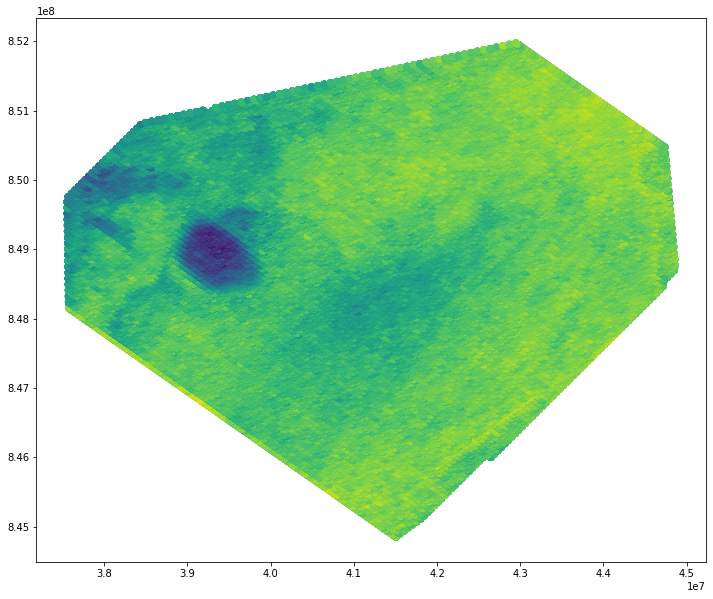

In [24]:
plt.figure(figsize=(12, 10))
plt.scatter(trace_x_culled, trace_y_culled, c=trace_culled)
plt.show()

### Conclusion
We have successfully performed a mathematical calculation on a 100GB seismic SEGY file without having to spin up or down a single computer.  All at the cost of $0.35 and 4 minutes of processing time.  This process is scalable and repeatable.  It can be expanded upon and automated with AWS Step Functions to orchestrate multiple steps and SageMaker to perform ML inference on the data.  Lambda concurrency can even be increased from the default 1000 to hundreds of thousands, greatly increasing performance.  

Of course, this calculation is not at the complexity of Full Waveform Inversion or other computations that require high performance computing (HPC).  However, if those calculations can be adjusted to work with Lambda (up to 6 vCPU, 10GB RAM, 15 minute limit), a huge amount of undifferentiated heavy lifting can be removed and offer an alternative to the complixity of scheduling thousands of EC2 spot instances.

### Cleanup

Lets clean up the files we generated, so that we can delete the CloudFormation stack without issue.

In [ ]:
for x in range(0, len(results_file_list)):
    _ = s3_client.delete_object(Bucket=results_bucket, Key=results_file_list[x])
    print("Deleting: {}".format(results_file_list[x]))